# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import time
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [2]:
!cp -r /content/drive/MyDrive/ML_PROJECTS/Computer_Vision/Facial_Emotion_Recognition/processed_data.zip /content

In [3]:
!unzip -q /content/processed_data.zip

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32
image_data_generator = ImageDataGenerator(rescale=1/255)

DATASET_DIR = "/content/processed_data"

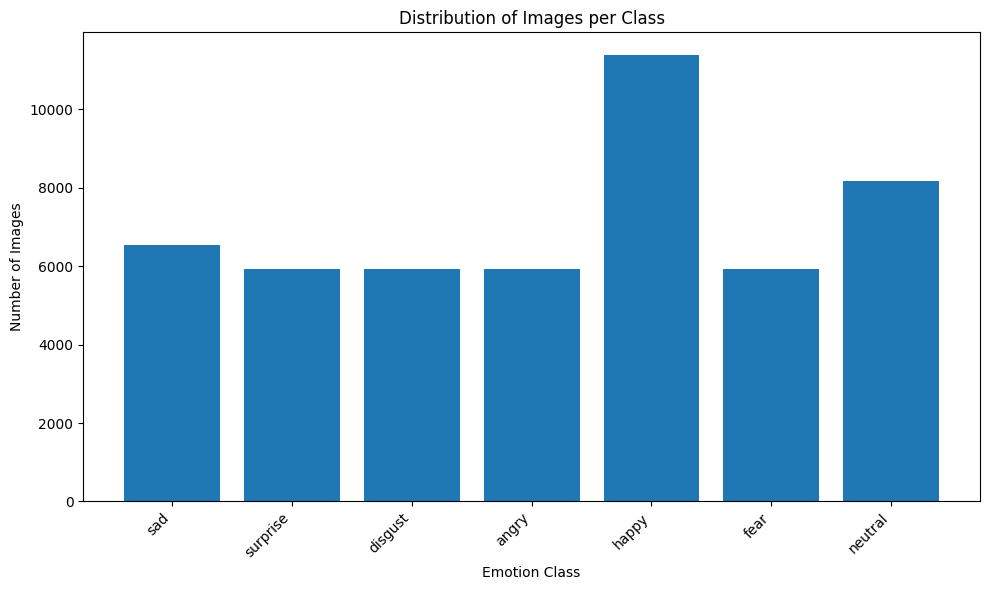

In [5]:
class_counts = {}
for emotion_folder in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion_folder)
    if os.path.isdir(emotion_path):
        class_counts[emotion_folder] = len(os.listdir(emotion_path))

class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.title('Distribution of Images per Class')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Spliting dataset into training, validation, and testing

In [7]:
np.random
training_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset='validation',
    seed = 42,
    image_size =(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)
val_size = int(0.5 * len(val_test_ds))
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

Found 49779 files belonging to 7 classes.
Using 39824 files for training.
Found 49779 files belonging to 7 classes.
Using 9955 files for validation.


# Optimize dataset pipeline

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(training_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Data Augmentation

In [9]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# MobileNetV2 model

In [10]:
base_model1 = tf.keras.applications.MobileNetV2(input_shape = (IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
base_model1.trainable = True

for layer in base_model1.layers[:100]:
    layer.trainable = False

base_model1.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [13]:
model1 = tf.keras.Sequential([
    data_augmentation,
    base_model1,
    layers.Flatten(),
    layers.Dense(112, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(training_ds.class_names), activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 112)            │     9,175,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           791 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,433,927 (43.62 MB)

 Trainable params: 11,037,383 (42.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

# Callback Function

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=1e-05, cooldown=0, min_lr=1e-07)
]

In [15]:
EPOCHS = 60
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[callbacks]
)
history1

Epoch 1/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 95s 47ms/step - accuracy: 0.2674 - loss: 1.9300 - val_accuracy: 0.3612 - val_loss: 1.6208 - learning_rate: 1.0000e-05
Epoch 2/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3461 - loss: 1.6411 - val_accuracy: 0.3916 - val_loss: 1.5169 - learning_rate: 1.0000e-05
Epoch 3/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3706 - loss: 1.5873 - val_accuracy: 0.4265 - val_loss: 1.4732 - learning_rate: 1.0000e-05
Epoch 4/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.3976 - loss: 1.5415 - val_accuracy: 0.4355 - val_loss: 1.4297 - learning_rate: 1.0000e-05
Epoch 5/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4230 - loss: 1.5045 - val_accuracy: 0.4471 - val_loss: 1.4033 - learning_rate: 1.0000e-05
Epoch 6/60
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4350 - loss: 1.4747 - val_accuracy: 0.4567 - val_loss: 1.3790 - learning_rate: 1.0000e-05
Epoch 7/60
1245/1245 ━━━━━━━━━━━━━━━━━━━

In [16]:
def plot(history):
    plt.figure(figsize=(10, 6))

    # Plot training & validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training & validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Predict Facial Emotion

In [17]:
def predict(model):
  predictions = model.predict(test_ds)
  print(f"Prediction \n{predictions}\n\n")

  predicted_classes = np.argmax(predictions, axis=1)
  print(f"Predicted labels\n{predicted_classes}\n")

  true_labels = np.concatenate([y for x, y in test_ds], axis=0)
  print(f"True labels\n{true_labels}\n")

  accuracy = np.mean(predicted_classes == true_labels)
  print(f"Test accuracy: {(accuracy * 100):.2f}%\n")


  # plot prediction vs true
  print("\nPrediction with image")
  class_names = training_ds.class_names
  plt.figure(figsize=(10,10))
  for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = class_names[predicted_classes[i]]
        true_class = class_names[labels[i]]
        plt.title(f"Predicted: {pred_class}\nTrue: {true_class}")
        plt.axis("off")
  plt.show()


  # Comfusion Matrix
  print("\n\nConfusion Matrix")
  cm = confusion_matrix(true_labels, predicted_classes)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(xticks_rotation=45)
  plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Prediction 
[[2.1577731e-03 6.4062819e-02 1.3545046e-03 ... 2.4379788e-01
  6.8557483e-01 1.7648701e-03]
 [3.9985585e-03 2.2301956e-03 9.3195005e-04 ... 4.7529950e-03
  4.6058446e-03 1.4778125e-03]
 [3.5499409e-03 6.6348800e-04 6.1861545e-05 ... 9.5074082e-04
  4.6064440e-04 1.5898773e-03]
 ...
 [6.7991042e-03 9.8091221e-01 6.5405807e-04 ... 2.0993243e-06
  3.7745500e-05 1.1589934e-02]
 [8.2931193e-03 1.9079700e-01 1.4110738e-02 ... 4.8574689e-01
  1.2691945e-01 1.5257320e-01]
 [9.9901482e-02 6.6453428e-03 2.8766153e-02 ... 6.1536472e-02
  4.5721631e-02 9.5378021e-03]]


Predicted labels
[5 3 3 ... 1 4 3]

True labels
[1 6 3 ... 3 4 2]

Test accuracy: 15.98%


Prediction with image


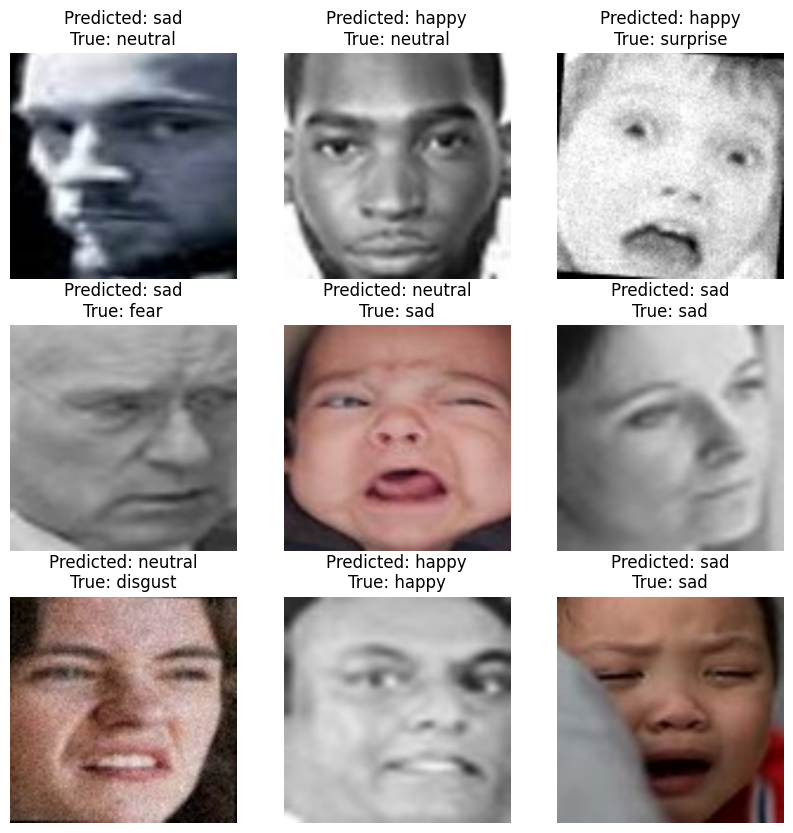



Confusion Matrix


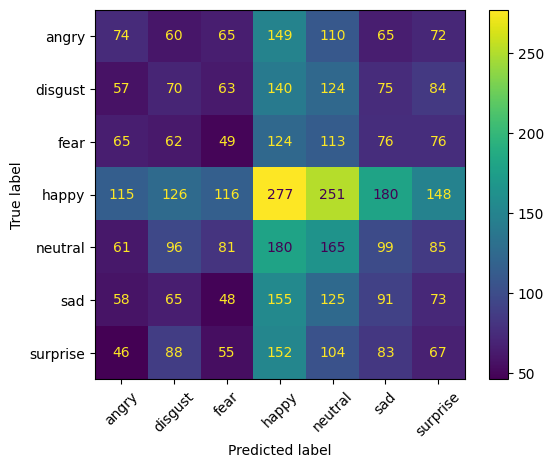

In [18]:
predict(model=model1)

In [ ]:
model_save_path = '/content/drive/MyDrive/ML_PROJECTS/Computer_Vision/Facial_Emotion_Recognition/Model/model_MobileNetV2.keras'
model1.save(model_save_path)

print(f"Model saved successfully to {model_save_path}")